In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import DenseNet121

In [3]:
# -----------------------------
# PARAMETERS
# -----------------------------
data_dir = "./dataset_new"   # Path to your dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
AUG_FACTOR = 3
EPOCHS = 15

In [4]:
# -----------------------------
# LOAD FILES & LABELS
# -----------------------------
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c: i for i, c in enumerate(classes)}

all_image_paths, all_labels = [], []
for cls in classes:
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([class_to_index[cls]] * len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Classes:", classes)
print("Original dataset size:", len(all_image_paths))

# -----------------------------
# PRINT CLASS DISTRIBUTION
# -----------------------------
for cls, idx in class_to_index.items():
    count = np.sum(all_labels == idx)
    print(f"{cls}: {count} images")


Classes: ['normal', 'osteoporosis']
Original dataset size: 1945
normal: 966 images
osteoporosis: 979 images


In [5]:
# -----------------------------
# NORMALIZATION FUNCTION 
# -----------------------------
def normalize_image_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.tile(img, [1, 1, 3])
    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])
    img = (img - mean) / std
    return img, label

# -----------------------------
# STRONG AUGMENTATION FUNCTION
# -----------------------------
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label




In [6]:
# -----------------------------
# BUILD DATASET
# -----------------------------
dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))
dataset = dataset.map(normalize_image_rgb, num_parallel_calls=AUTOTUNE)

In [7]:
# -----------------------------
# SPLIT TRAIN / VAL / TEST (50/25/25)
# -----------------------------
dataset_size = len(all_image_paths)
train_size = int(0.5 * dataset_size)
val_size = int(0.25 * dataset_size)
test_size = dataset_size - train_size - val_size  
dataset = dataset.shuffle(dataset_size, reshuffle_each_iteration=False)
train_ds = dataset.take(train_size)
val_test_ds = dataset.skip(train_size)
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

print("Train size:", sum(1 for _ in train_ds))
print("Val size  :", sum(1 for _ in val_ds))
print("Test size :", sum(1 for _ in test_ds))


Train size: 972
Val size  : 486
Test size : 487


In [8]:
# -----------------------------
# AUGMENT TRAINING DATA
# -----------------------------
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE).repeat(AUG_FACTOR)
train_ds = train_ds.shuffle(buffer_size=train_size * AUG_FACTOR)

# -----------------------------
# BATCH & PREFETCH
# -----------------------------
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [9]:
# -----------------------------
# MODEL WITH DenseNet121
# -----------------------------
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = True  # fine-tune entire base

# ADD CUSTOM CLASSIFIER
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # binary classification

model = models.Model(inputs=base_model.input, outputs=outputs)

# -----------------------------
# COMPILE MODEL
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,304,257 (27.86 MB)

 Trainable params: 7,218,561 (27.54 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [10]:
# -----------------------------
# CALLBACKS
# -----------------------------
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# -----------------------------
# TRAIN MODEL
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 2539s 6s/step - accuracy: 0.7483 - loss: 0.5357 - val_accuracy: 0.8189 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 2139s 6s/step - accuracy: 0.8457 - loss: 0.3803 - val_accuracy: 0.8498 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 1683s 4s/step - accuracy: 0.8865 - loss: 0.2928 - val_accuracy: 0.8971 - val_loss: 0.3397 - learning_rate: 1.0000e-04
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 1704s 4s/step - accuracy: 0.9102 - loss: 0.2369 - val_accuracy: 0.9053 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 1595s 4s/step - accuracy: 0.9122 - loss: 0.2222 - val_accuracy: 0.9218 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 1614s 4s/step - accuracy: 0.9331 - loss: 0.1733 - val_accuracy: 0.8560 - val_loss: 0.4148 - learning_rate: 1.0000e-04
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 1586s 4s/ste

In [11]:
def evaluate_model(model, dataset, split_name="Dataset"):
    classes = ["normal", "osteoporosis"]
    y_true, y_pred = [], []

    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_true == y_pred)
    print(f"\n{split_name} Accuracy: {acc*100:.2f}%\n")

    print(f"{split_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Train Accuracy: 97.81%

Train Classification Report:
              precision    recall  f1-score   support

      normal       0.98      0.97      0.98      1455
osteoporosis       0.97      0.98      0.98      1461

    accuracy                           0.98      2916
   macro avg       0.98      0.98      0.98      2916
weighted avg       0.98      0.98      0.98      2916



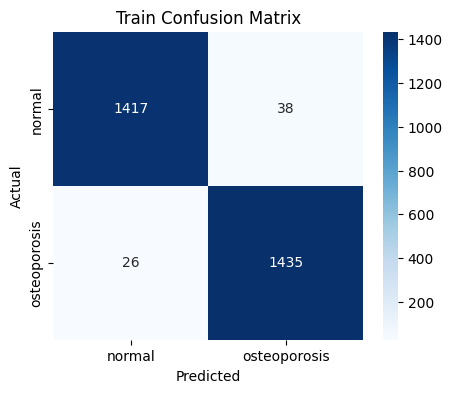


Validation Accuracy: 95.27%

Validation Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.97      0.95       248
osteoporosis       0.97      0.93      0.95       238

    accuracy                           0.95       486
   macro avg       0.95      0.95      0.95       486
weighted avg       0.95      0.95      0.95       486



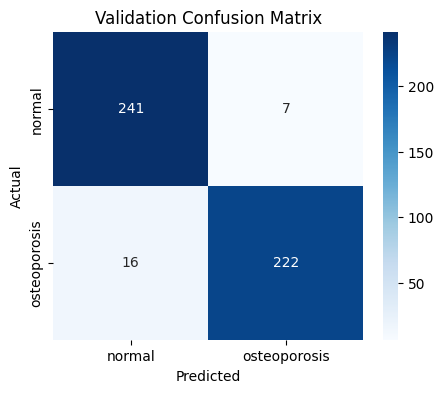


Test Accuracy: 93.22%

Test Classification Report:
              precision    recall  f1-score   support

      normal       0.92      0.94      0.93       233
osteoporosis       0.94      0.93      0.93       254

    accuracy                           0.93       487
   macro avg       0.93      0.93      0.93       487
weighted avg       0.93      0.93      0.93       487



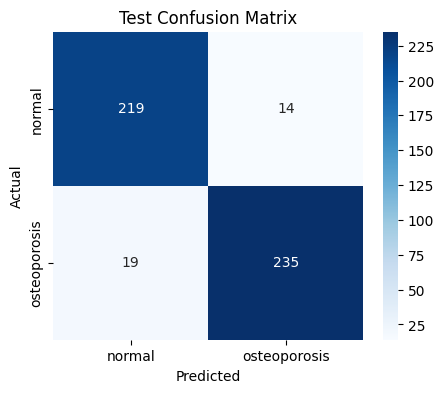

In [12]:
# =========================
# Run evaluation
# =========================
evaluate_model(model, train_ds, split_name="Train")
evaluate_model(model, val_ds, split_name="Validation")
evaluate_model(model, test_ds, split_name="Test")